## Predicting Crashes in Financial Markets - SVM linear
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BSESN (India), SMI (Switzerland), BVSP (Brazil)
- Model: Support Vecor Machines (SVM) linear
- Number of features: 16 (mean price change and volatility for different windows over past 252 days)
- Response variable: Crash within 1 / 3 / 6 months (0: no, 1:yes)
- Crash definition: Drawdown in 99.5% quantile

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
from prepare_data_3 import DataLoader

In [56]:
# -------------------- Data preparation -------------------- #
os.chdir('/home/roman/Documents/Projects/Bubbles/data')
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
data = DataLoader(datasets_original, dataset_names)

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344]
df_combined, drawdowns, crashes = data.get_df_combined(crash_thresholds)
months = 1                # <-- predict if crash n months ahead
sequence = None           # <-- number of days lookback as input(only if select_features=False)
dfs_xy = data.get_df_xy(months=months, sequence=sequence, df_combined=df_combined, crashes=crashes)

In [57]:
# -------------------- Train SVM linear -------------------- #
model_name = 'SVM: linear Classification'
y_train_all = []
y_test_all = []
y_pred_tr_all = []
y_pred_t_all = []
for test_data in dataset_names[1:]:
    np_train, np_test = data.get_train_test(dfs_xy, dataset_names, test_data=test_data)
    x_train = np_train[:, 0:-1]
    y_train = np_train[:, -1].astype(int)
    y_train_all.append(y_train)
    x_test = np_test[:, 0:-1]
    y_test = np_test[:, -1].astype(int)
    y_test_all.append(y_test)
    print('Train ' + str(model_name) + ' - test data: ' + str(test_data))
    clf = svm.SVC(C=1, kernel='linear', class_weight={0:.025, 1:.975})
    model = clf.fit(x_train, y_train)
    y_pred_tr = model.predict(x_train)
    y_pred_tr_all.append(y_pred_tr)
    y_pred_t = model.predict(x_test)
    y_pred_t_all.append(y_pred_t)

Train SVM: linear Classification - test data: N225
Train SVM: linear Classification - test data: SSE
Train SVM: linear Classification - test data: HSI
Train SVM: linear Classification - test data: BSESN
Train SVM: linear Classification - test data: SMI
Train SVM: linear Classification - test data: BVSP


In [58]:
# -------------------- Evaluate results -------------------- #
beta = 2
precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_t_bin_all = []
y_pred_tr_bin_all = []
score_fbeta_tr = []
score_fbeta_t = []
for y_train, y_test, y_pred_tr, y_pred_t in zip(y_train_all, y_test_all, \
                                                y_pred_tr_all, y_pred_t_all):
    y_pred_tr_bin = y_pred_tr.astype(int)
    y_pred_tr_bin_all.append(y_pred_tr_bin)
    precision_tr.append(metrics.precision_score(y_train, y_pred_tr_bin))
    recall_tr.append(metrics.recall_score(y_train, y_pred_tr_bin))
    accuracy_tr.append(metrics.accuracy_score(y_train, y_pred_tr_bin))
    score_fbeta_tr.append(metrics.fbeta_score(y_train, y_pred_tr_bin, beta=beta))
    y_pred_t_bin = y_pred_t.astype(int)
    y_pred_t_bin_all.append(y_pred_t_bin)
    precision_t.append(metrics.precision_score(y_test, y_pred_t_bin))
    recall_t.append(metrics.recall_score(y_test, y_pred_t_bin))
    accuracy_t.append(metrics.accuracy_score(y_test, y_pred_t_bin))
    score_fbeta_t.append(metrics.fbeta_score(y_test, y_pred_t_bin, beta=beta))

y_tr_pos = [np.mean(y) for y in y_train_all]
y_tr_pred_pos = [np.mean(y_pred) for y_pred in y_pred_tr_bin_all]
y_t_pos = [np.mean(y) for y in y_test_all]
y_t_pred_pos = [np.mean(y_pred) for y_pred in y_pred_t_bin_all]
d = {'positive actual tr': np.round(y_tr_pos, 2), \
     'positive pred tr': np.round(y_tr_pred_pos, 2), \
     'precision tr': np.round(precision_tr,2), \
     'recall tr': np.round(recall_tr,2), 'accuracy_tr': np.round(accuracy_tr,2), \
     'score fbeta tr': np.round(score_fbeta_tr,2), \
     'positive actual t': np.round(y_t_pos, 2), \
     'positive pred t': np.round(y_t_pred_pos, 2), \
     'precision t': np.round(precision_t,2), \
     'recall t': np.round(recall_t,2), 'accuracy_t': np.round(accuracy_t,2), \
     'score fbeta t': np.round(score_fbeta_t,2)}
results = pd.DataFrame.from_dict(d, orient='index')
results.columns = dataset_names[1:]
print('Results (for each train/test splits) -' + model_name + ':')
print(results)
print('\n')

# calculate precision, recall, accuracy for comparable random model
sum_tr = 0
sum_t = 0
pos_tr = 0
pos_t = 0
sum_tr_pred = 0
sum_t_pred = 0
pos_tr_pred = 0
pos_t_pred = 0
for y_tr, y_t, y_tr_pr, y_t_pr in zip(y_train_all, y_test_all, y_pred_tr_bin_all, \
                y_pred_tr_bin_all):
    sum_tr += len(y_tr)
    pos_tr += sum(y_tr)
    sum_t += len(y_t)
    pos_t += sum(y_t)
    sum_tr_pred += len(y_tr_pr)
    sum_t_pred += len(y_tr_pr)
    pos_tr_pred += sum(y_t_pr)#[0]
    pos_t_pred += sum(y_t_pr)#[0]
y_train_pos_actual = pos_tr / sum_tr
y_train_pos_pred = pos_tr_pred / sum_tr_pred
rnd_TP = y_train_pos_pred * y_train_pos_actual
rnd_FP = y_train_pos_pred * (1 - y_train_pos_actual)
rnd_TN = (1 - y_train_pos_pred) * (1 - y_train_pos_actual)
rnd_FN = (1 - y_train_pos_pred) * y_train_pos_actual
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
y_test_pos_actual = pos_t / sum_t
y_test_pos_pred = pos_t_pred / sum_t_pred
rnd_TP = y_test_pos_pred * y_test_pos_actual
rnd_FP = y_test_pos_pred * (1 - y_test_pos_actual)
rnd_TN = (1 - y_test_pos_pred) * (1 - y_test_pos_actual)
rnd_FN = (1 - y_test_pos_pred) * y_test_pos_actual
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

print('Results (average over all train/test splits) -' + model_name + ':')
print('Number of features: ' + str(sequence) + '; number of rows: ' \
      + str(sum_tr + sum_t))
print('Positive train cases actual:        '+ str(round(y_train_pos_actual, 2)))
print('Positive train cases predicted:     '+ str(round(y_train_pos_pred, 2)))
print('Avg precision train (model/random): '+ str(round(np.mean(precision_tr), 2)) +' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(np.mean(recall_tr), 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(np.mean(accuracy_tr), 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train fbeta:                  '+ str(round(np.mean(score_fbeta_tr), 2)))
print('Positive test cases actual:         '+ str(round(y_test_pos_actual, 2)))
print('Positive test cases predicted:      '+ str(round(y_test_pos_pred, 2)))
print('Avg precision test (model/random):  '+ str(round(np.mean(precision_t), 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(np.mean(recall_t), 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(np.mean(accuracy_t), 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test fbeta:                   '+ str(round(np.mean(score_fbeta_t), 2)))

Results (for each train/test splits) -SVM: linear Classification:
                    N225   SSE   HSI  BSESN   SMI  BVSP
positive actual tr  0.02  0.02  0.02   0.02  0.02  0.02
positive pred tr    0.12  0.10  0.11   0.11  0.11  0.11
precision tr        0.10  0.10  0.10   0.10  0.09  0.09
recall tr           0.72  0.61  0.64   0.63  0.61  0.62
accuracy_tr         0.89  0.91  0.90   0.90  0.90  0.89
score fbeta tr      0.32  0.31  0.31   0.30  0.29  0.29
positive actual t   0.02  0.02  0.02   0.02  0.02  0.02
positive pred t     0.16  0.10  0.10   0.11  0.10  0.07
precision t         0.04  0.09  0.06   0.08  0.12  0.16
recall t            0.33  0.62  0.38   0.51  0.71  0.63
accuracy_t          0.84  0.90  0.90   0.89  0.91  0.93
score fbeta t       0.12  0.29  0.18   0.24  0.37  0.39


Results (average over all train/test splits) -SVM: linear Classification:
Number of features: None; number of rows: 358428
Positive train cases actual:        0.02
Positive train cases predicted:     0.11

In [59]:
# -------------------- Test model -------------------- #
np_train, np_test = data.get_train_test(dfs_xy, dataset_names, test_data='S&P 500')
x_train = np_train[:, 0:-1]
y_train = np_train[:, -1].astype(int)
x_test = np_test[:, 0:-1]
y_test = np_test[:, -1].astype(int)
clf = svm.SVC(C=1, kernel='rbf', class_weight={0:.025, 1:.975})
model = clf.fit(x_train, y_train)
y_pred_t_bin = model.predict(x_test).astype(int)
precision_t = metrics.precision_score(y_test, y_pred_t_bin)
recall_t = metrics.recall_score(y_test, y_pred_t_bin)
accuracy_t = metrics.accuracy_score(y_test, y_pred_t_bin)
score_fbeta_t = metrics.fbeta_score(y_test, y_pred_t_bin, beta=beta)

y_t_pos = np.mean(y_test)
y_t_pred_pos = np.mean(y_pred_t_bin)
rnd_TP = y_t_pred_pos * y_t_pos
rnd_FP = y_t_pred_pos * (1 - y_t_pos)
rnd_TN = (1 - y_t_pred_pos) * (1 - y_t_pos)
rnd_FN = (1 - y_t_pred_pos) * y_t_pos
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN
rnd_fbeta = (1 + beta ** 2) * (rnd_pr_t * rnd_re_t) / ((beta ** 2 * rnd_pr_t) + rnd_re_t)
print('Test results (test set: S&P 500) - ' + model_name + ':')
print('Positive test cases actual:         '+ str(round(y_t_pos, 2)))
print('Positive test cases predicted:      '+ str(round(y_t_pred_pos, 2)))
print('Precision test (model/random):      '+ str(round(np.mean(precision_t), 2))+' / '+str(round(rnd_pr_t, 2)))
print('Recall test (model/random):         '+ str(round(np.mean(recall_t), 2))+' / '+str(round(rnd_re_t, 2)))
print('Accuracy test (model/random):       '+ str(round(np.mean(accuracy_t), 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test fbeta:                   '+ str(round(np.mean(score_fbeta_t), 2))+' / '+str(round(rnd_fbeta, 2)))

Test results (test set: S&P 500) - SVM: linear Classification:
Positive test cases actual:         0.02
Positive test cases predicted:      0.09
Precision test (model/random):      0.09 / 0.02
Recall test (model/random):         0.51 / 0.09
Accuracy test (model/random):       0.91 / 0.9
Score test fbeta:                   0.26 / 0.05


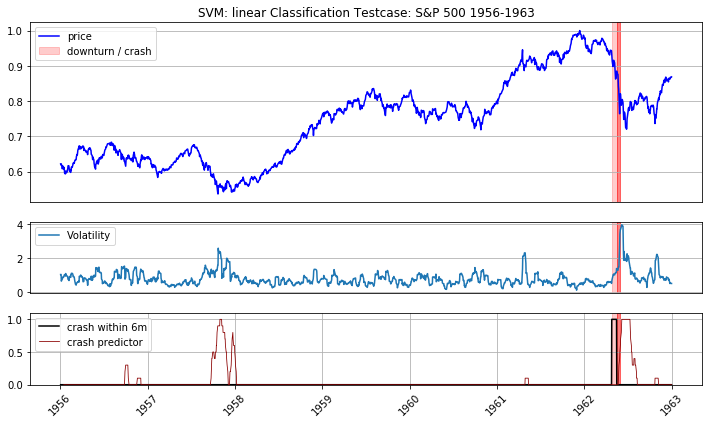

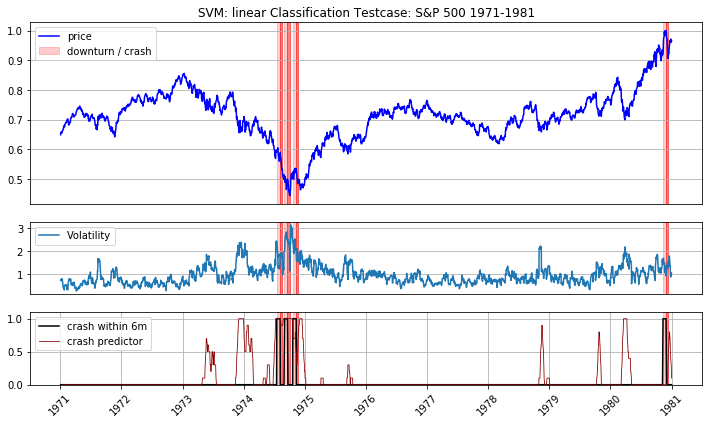

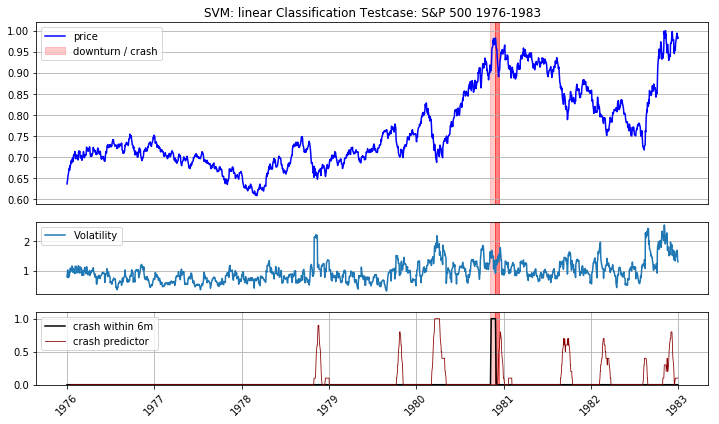

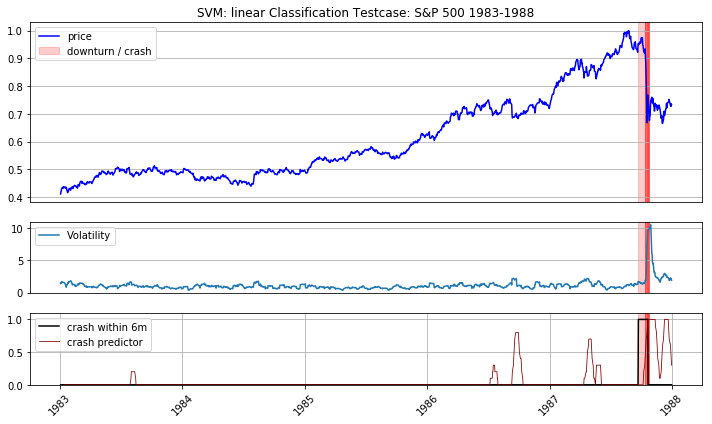

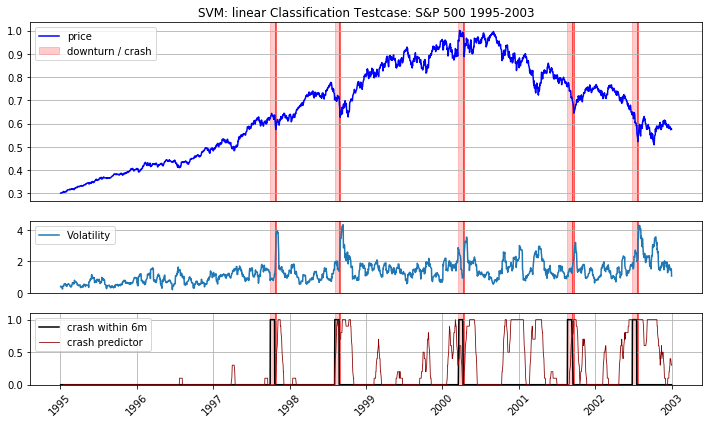

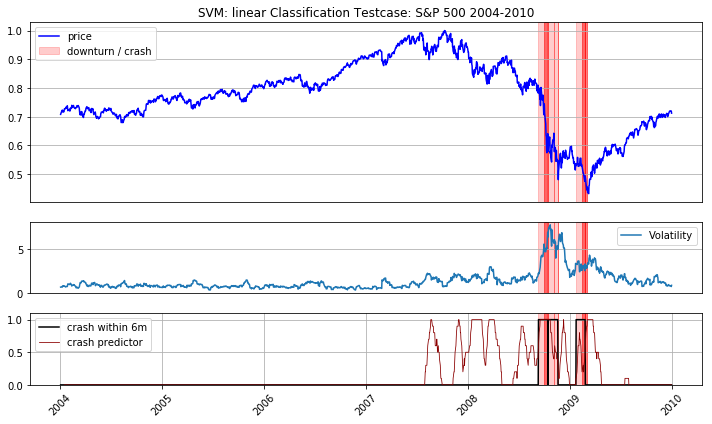

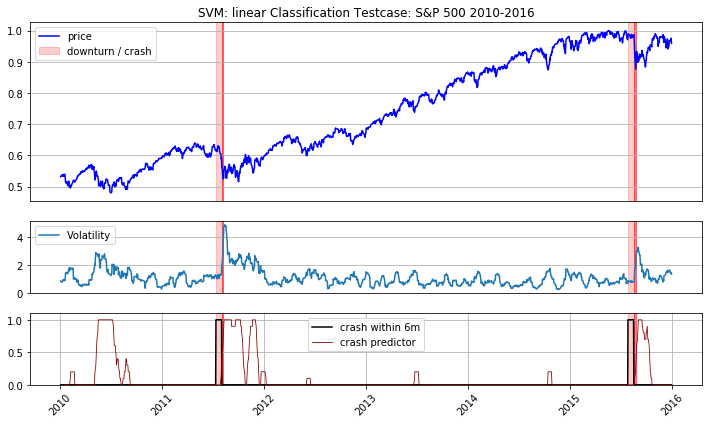

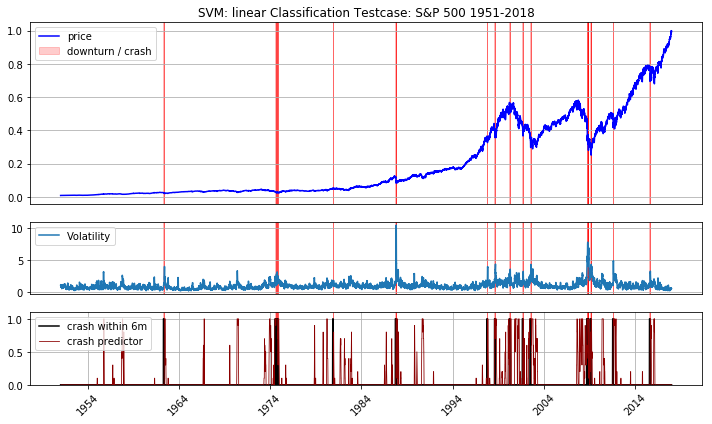

In [60]:
# -------------------- Plot test results -------------------- #
df = df_combined[0].reindex(dfs_xy[0].index)
df['y'] = y_test
df['y_pred'] = y_pred_t_bin
c = crashes[0]

test_data = 'S&P 500'
# i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
# dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
#             y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
# df = dfs_predict[i]
# c = crashes[i]
t_start = [datetime.strptime('1956-01-01', '%Y-%m-%d'), datetime.strptime('1971-01-01', '%Y-%m-%d'), \
           datetime.strptime('1976-01-01', '%Y-%m-%d'), datetime.strptime('1983-01-01', '%Y-%m-%d'), \
           datetime.strptime('1995-01-01', '%Y-%m-%d'), datetime.strptime('2004-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d'), datetime.strptime('1951-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('1963-01-01', '%Y-%m-%d'), datetime.strptime('1981-01-01', '%Y-%m-%d'), \
         datetime.strptime('1983-01-01', '%Y-%m-%d'), datetime.strptime('1988-01-01', '%Y-%m-%d'), \
         datetime.strptime('2003-01-01', '%Y-%m-%d'), datetime.strptime('2010-01-01', '%Y-%m-%d'), \
         datetime.strptime('2016-01-01', '%Y-%m-%d'), datetime.strptime('2018-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  